In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [32]:
earthquakes = pd.read_csv('all_month.csv')
earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9229 entries, 0 to 9228
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             9229 non-null   object 
 1   latitude         9229 non-null   float64
 2   longitude        9229 non-null   float64
 3   depth            9229 non-null   float64
 4   mag              9229 non-null   float64
 5   magType          9229 non-null   object 
 6   nst              7757 non-null   float64
 7   gap              7757 non-null   float64
 8   dmin             7735 non-null   float64
 9   rms              9228 non-null   float64
 10  net              9229 non-null   object 
 11  id               9229 non-null   object 
 12  updated          9229 non-null   object 
 13  place            9229 non-null   object 
 14  type             9229 non-null   object 
 15  horizontalError  7182 non-null   float64
 16  depthError       9221 non-null   float64
 17  magError      

In [33]:
earthquakes.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-05-24T02:21:41.496Z,32.377000,-101.471000,5.00,1.20,ml,6.0,232.0,0.100000,0.80,...,2025-05-24T02:23:56.384Z,"14 km N of Big Spring, Texas",earthquake,0.00,NaN,0.300,6.0,automatic,tx,tx
1,2025-05-24T02:07:34.440Z,38.834667,-122.818665,1.86,0.40,md,8.0,89.0,0.013100,0.01,...,2025-05-24T02:09:10.580Z,"8 km NNW of The Geysers, CA",earthquake,0.44,1.26,0.240,9.0,automatic,nc,nc
2,2025-05-24T01:55:04.430Z,38.814499,-122.832497,1.46,0.76,md,7.0,137.0,0.006192,0.01,...,2025-05-24T02:27:16.322Z,"8 km NW of The Geysers, CA",earthquake,0.44,0.85,0.090,10.0,automatic,nc,nc
3,2025-05-24T01:54:13.580Z,38.834667,-122.818169,1.77,0.78,md,14.0,87.0,0.012910,0.01,...,2025-05-24T02:17:22.249Z,"8 km NNW of The Geysers, CA",earthquake,0.30,0.69,0.150,17.0,automatic,nc,nc
4,2025-05-24T01:26:58.060Z,33.501333,-116.507833,12.02,0.87,ml,31.0,57.0,0.079130,0.14,...,2025-05-24T01:30:27.655Z,"16 km ESE of Anza, CA",earthquake,0.18,0.41,0.127,26.0,automatic,ci,ci


In [34]:
earthquakes.isnull().sum()

time                  0
latitude              0
longitude             0
depth                 0
mag                   0
magType               0
nst                1472
gap                1472
dmin               1494
rms                   1
net                   0
id                    0
updated               0
place                 0
type                  0
horizontalError    2047
depthError            8
magError           1494
magNst             1473
status                0
locationSource        0
magSource             0
dtype: int64

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/matplotlib/collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


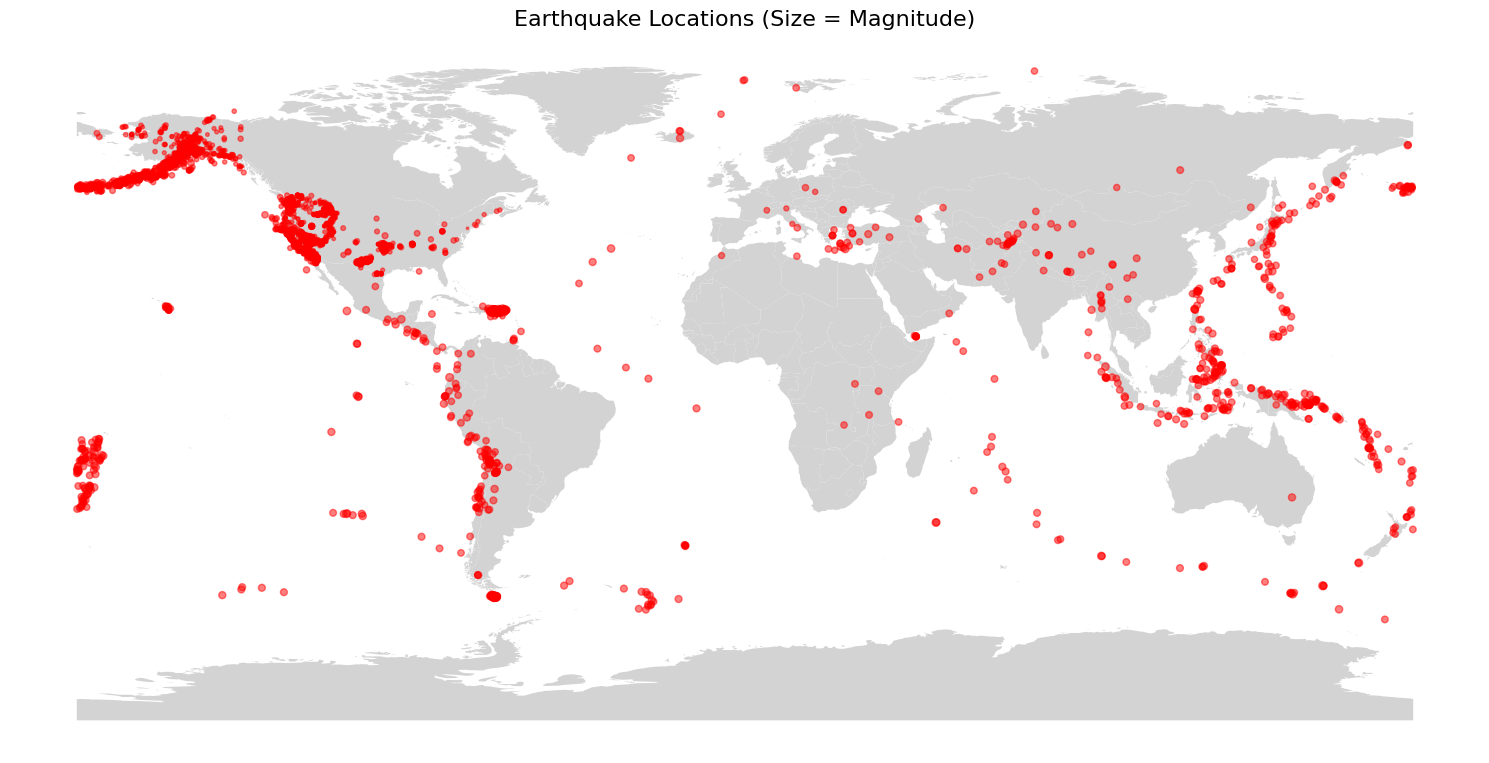

In [35]:
# Convert latitude and longitude into point locations
geometry = [Point(xy) for xy in zip(earthquakes["longitude"], earthquakes["latitude"])]
quake_gdf = gpd.GeoDataFrame(earthquakes, geometry=geometry, crs="EPSG:4326")

# Load a world map file
world = gpd.read_file("ne_50m_admin_0_countries.shp")

# Join earthquakes to countries by location
result = gpd.sjoin(quake_gdf, world, how="left", predicate="intersects")

# Plot a world map with earthquake points
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the base world map in light gray
world.plot(ax=ax, color="lightgray")

# Plot earthquake points in red, with size based on magnitude
result.plot(
    ax=ax,
    markersize=result["mag"] * 5,  # Adjust the multiplier for better visibility
    alpha=0.5,
    color="red"
)

# Add title and remove axis lines
ax.set_title("Earthquake Locations (Size = Magnitude)", fontsize=16)
ax.axis("off")

# Show the map
plt.tight_layout()
plt.show()



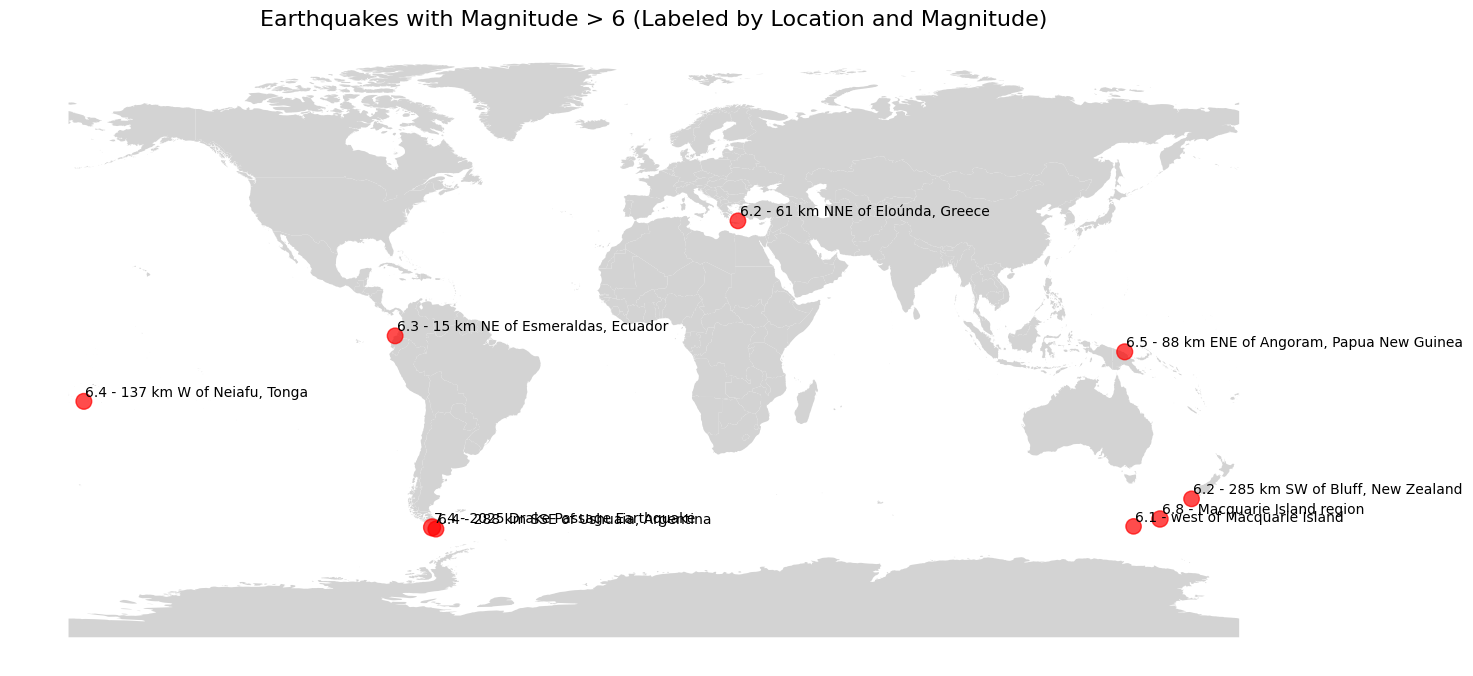

In [36]:
# Filter only earthquakes with magnitude > 6
high_mag_quakes = result[result["mag"] > 6]

fig, ax = plt.subplots(figsize=(15, 10))

# Plot base map
world.plot(ax=ax, color="lightgray")

# Plot high-magnitude quakes
high_mag_quakes.plot(
    ax=ax,
    markersize=high_mag_quakes["mag"] * 20,
    alpha=0.7,
    color="red"
)

# Add labels - mag + location
for idx, row in high_mag_quakes.iterrows():
    mag = row["mag"]
    lon = row["geometry"].x
    lat = row["geometry"].y
    location = row.get("place") or row.get("ADMIN") or "Unknown"
    
    ax.text(
        lon + 0.5, lat + 1.5,  # Slight offset to avoid overlap
        f"{mag:.1f} - {location}",
        fontsize=10,
        color="black"
    )

# Add title and show the map
ax.set_title("Earthquakes with Magnitude > 6 (Labeled by Location and Magnitude)", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()

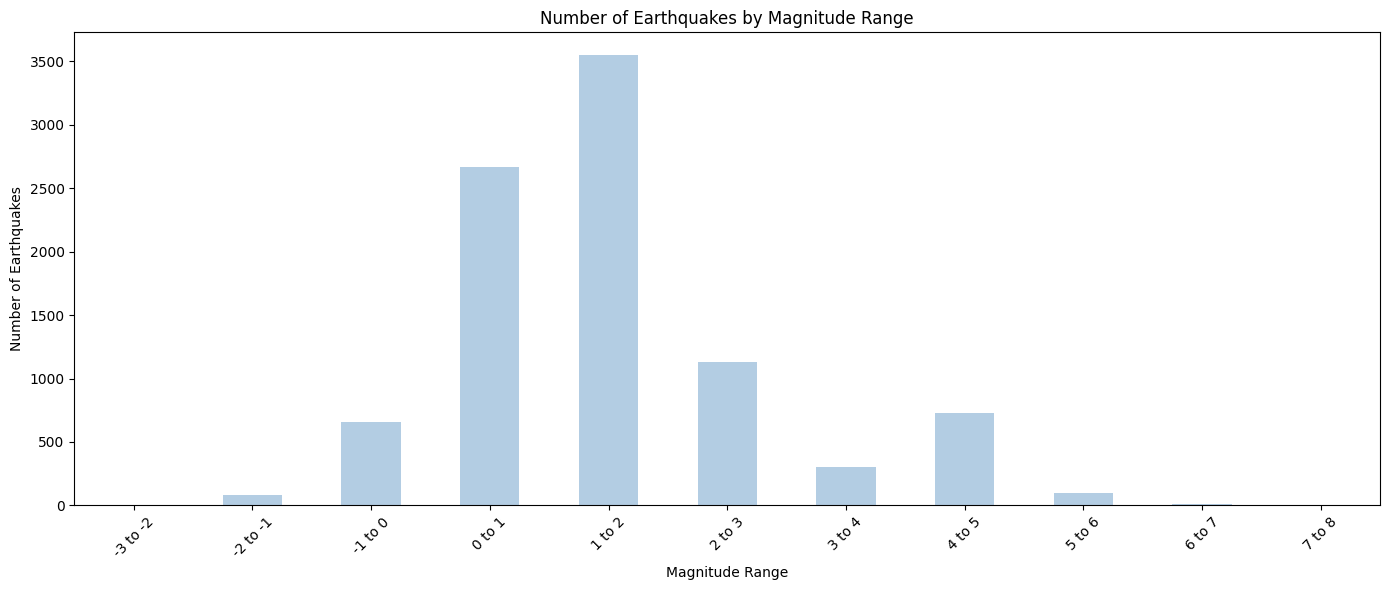

In [37]:
# Create bin to do by range of magnitude
bins = [-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
labels = ['-3 to -2', '-2 to -1', '-1 to 0', '0 to 1', '1 to 2', '2 to 3', '3 to 4', '4 to 5', '5 to 6', '6 to 7', '7 to 8']

# Put data to each bin
earthquakes['mag_bin'] = pd.cut(earthquakes['mag'], bins=bins, labels=labels, right=True)

# Count by value of each bin
mag_counts = earthquakes['mag_bin'].value_counts().sort_index()

# Plot the bar chart
fig, ax = plt.subplots(figsize=(14, 6))
mag_counts.plot(kind='bar', color="#b3cde3", ax=ax)

# Add label, tiltle and show chart
ax.set_xlabel("Magnitude Range")
ax.set_ylabel("Number of Earthquakes")
ax.set_title("Number of Earthquakes by Magnitude Range")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

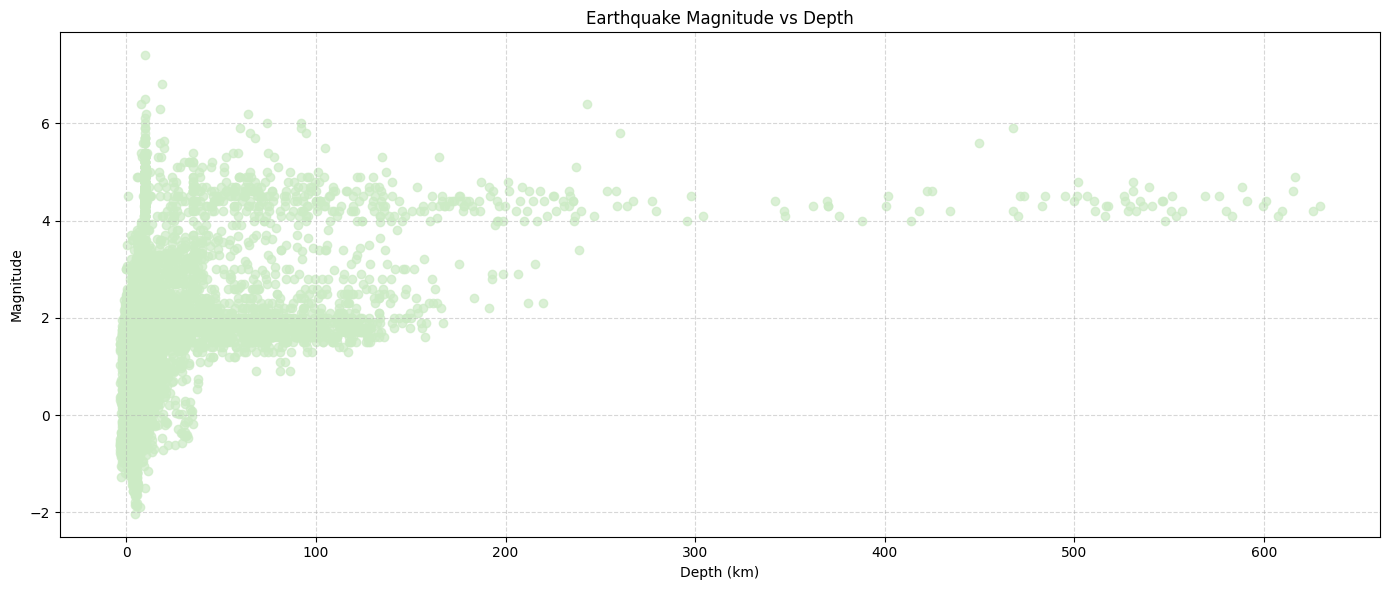

In [38]:
# Scatter plot
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(earthquakes['depth'], earthquakes['mag'], color="#ccebc5", alpha=0.7)

# Labels and title
ax.set_xlabel('Depth (km)')
ax.set_ylabel('Magnitude')
ax.set_title('Earthquake Magnitude vs Depth')

# Grid
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


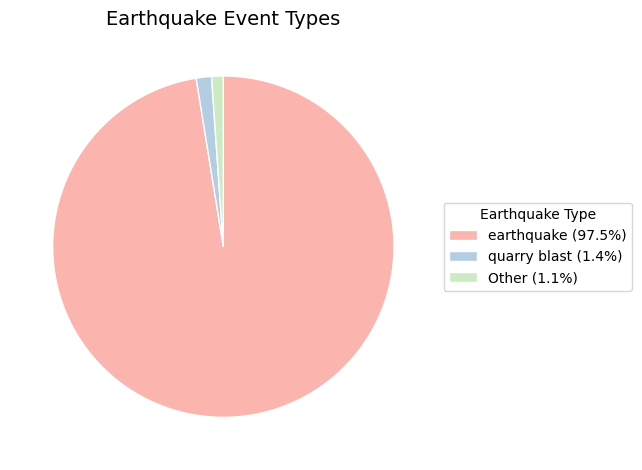

In [39]:
# Count each type of earthquake
eq_type_counts = earthquakes['type'].value_counts()

# Group small categories into "Other"
threshold = 100
main_types = eq_type_counts[eq_type_counts >= threshold]
other_count = eq_type_counts[eq_type_counts < threshold].sum()

# Combine data for plotting
plot_data = main_types.copy()
if other_count > 0:
    plot_data["Other"] = other_count

# Calculate percentages for legend
percentages = (plot_data / plot_data.sum() * 100).round(1)
labels = [f"{typ} ({pct}%)" for typ, pct in zip(plot_data.index, percentages)]

# Plot pie without inner labels
fig, ax = plt.subplots()
colors = plt.cm.Pastel1.colors

wedges, _ = ax.pie(
    plot_data,
    startangle=90,
    counterclock=False,
    colors=colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

# Show legend with percentages
ax.legend(wedges, labels, title="Earthquake Type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title('Earthquake Event Types', fontsize=14)
plt.tight_layout()
plt.show()

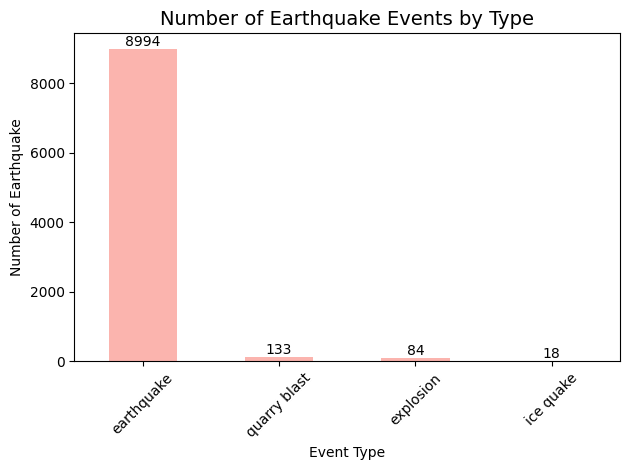

In [40]:
# plot bar charge 
fig, ax = plt.subplots()
eq_type_counts.plot(kind='bar', color="#fbb4ae", ax=ax) 

# Add title and show count above bars
ax.set_title("Number of Earthquake Events by Type", fontsize=14)
ax.set_xlabel("Event Type")
ax.set_ylabel("Number of Earthquake")
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

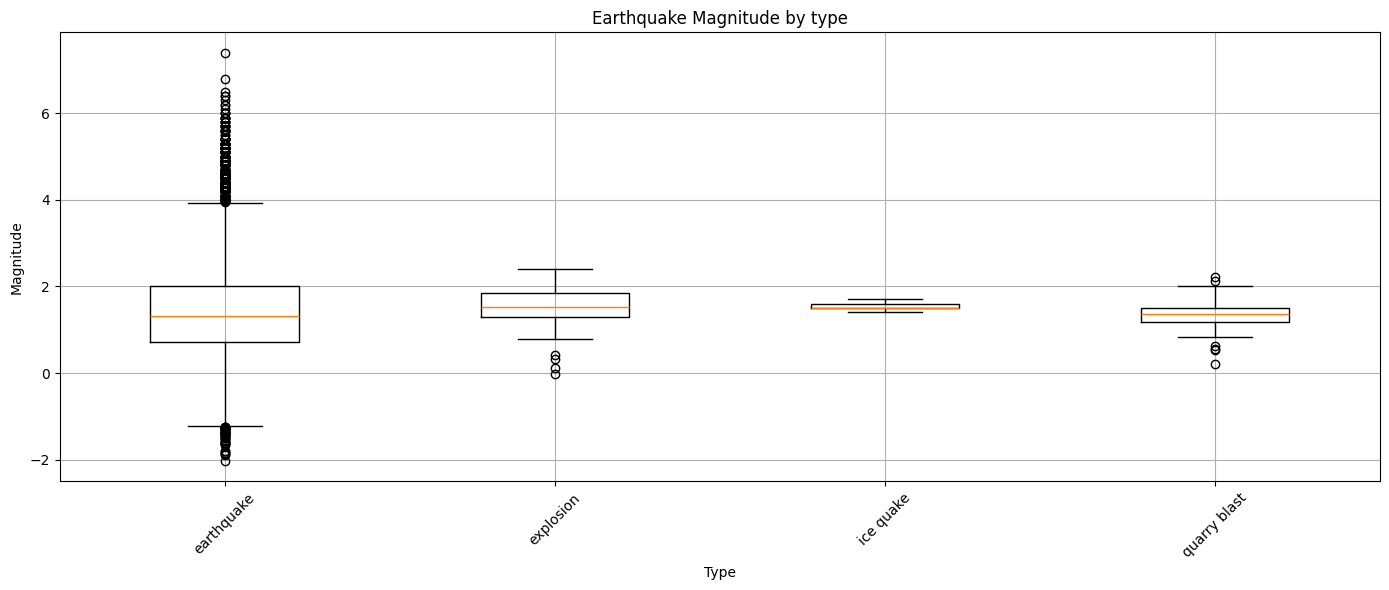

In [41]:
# Group by type and collect magnitude values
mag_by_type = earthquakes.groupby('type')['mag'].apply(list)

# Plot box plot
plt.figure(figsize=(14, 6))
plt.boxplot(mag_by_type, tick_labels=mag_by_type.index)
plt.title('Earthquake Magnitude by type')
plt.xlabel('Type')
plt.ylabel('Magnitude')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

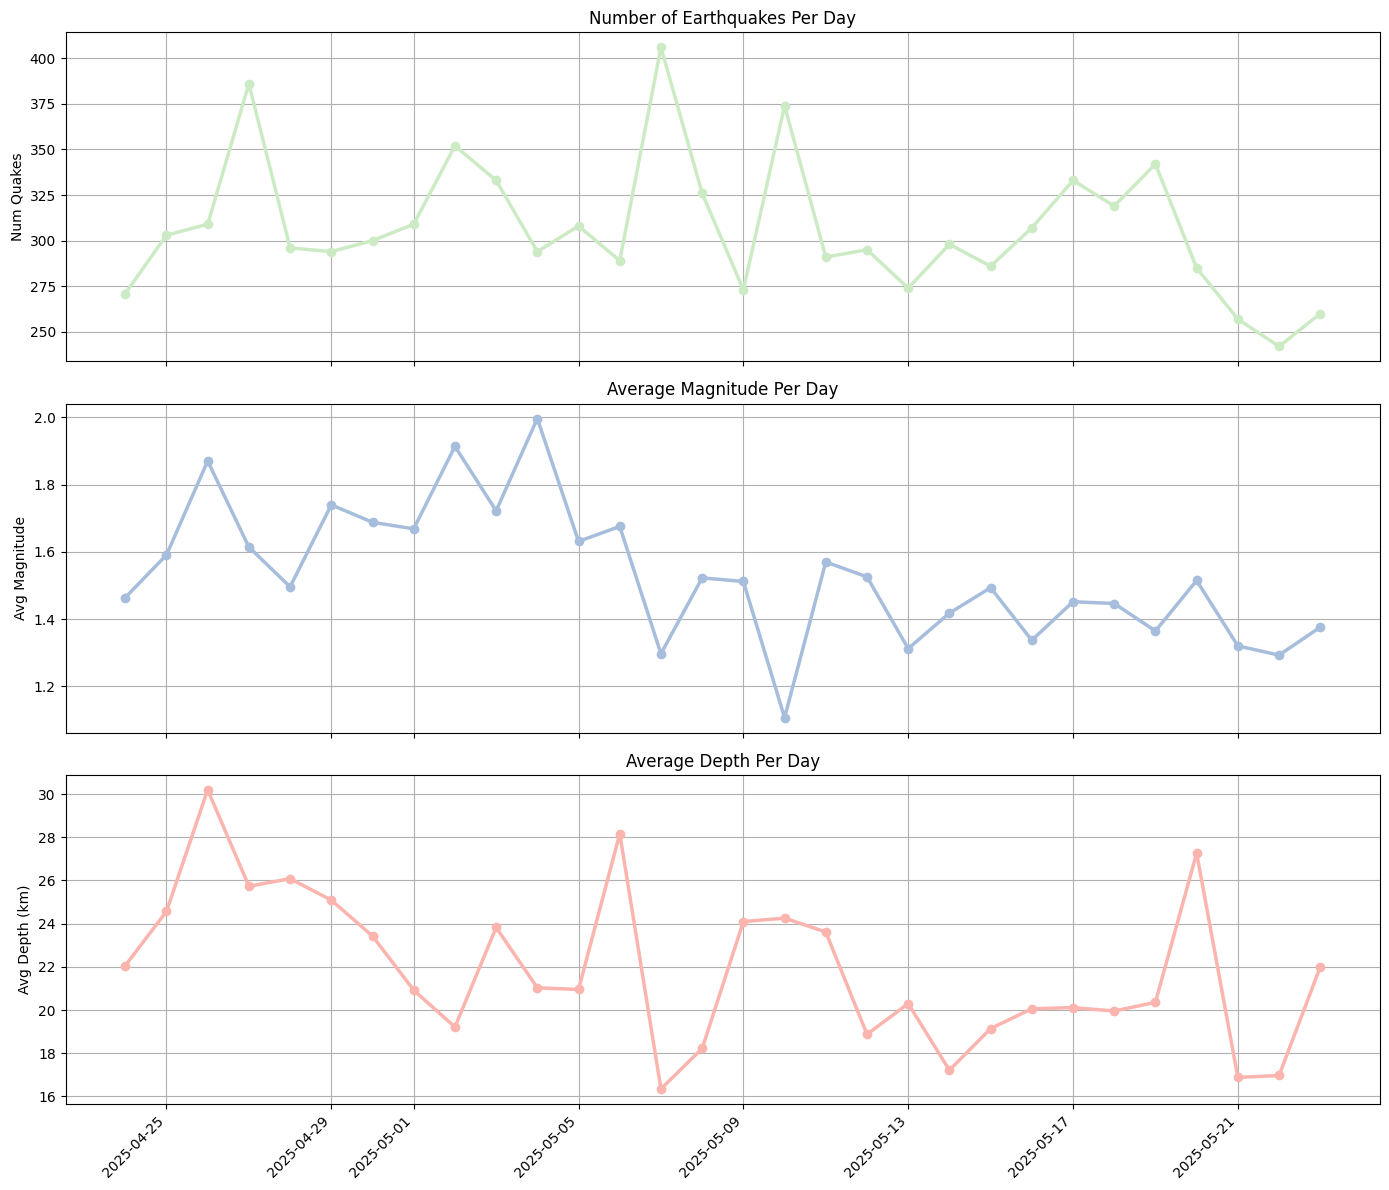

In [42]:
# convert time column to date and day of the week
earthquakes['time'] = pd.to_datetime(earthquakes['time'])
earthquakes['date'] = earthquakes['time'].dt.date
earthquakes['day_of_week'] = earthquakes['time'].dt.day_name()

# Group by day
daily_stats = earthquakes.groupby('date').agg(
    num_quakes=('time', 'count'),
    avg_mag=('mag', 'mean'),
    avg_depth=('depth', 'mean')
).sort_index()

# Cut the last day out
last_day = earthquakes['date'].max()
filtered_stats = daily_stats[daily_stats.index != last_day]

fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot Number of Earthquakes
axs[0].plot(filtered_stats.index, filtered_stats['num_quakes'], marker='o', color='#ccebc5', linewidth=2.5)
axs[0].set_title('Number of Earthquakes Per Day')
axs[0].set_ylabel('Num Quakes')
axs[0].grid(True)

# Plot Average Magnitude
axs[1].plot(filtered_stats.index, filtered_stats['avg_mag'], marker='o', color='#a6bddb', linewidth=2.5)
axs[1].set_title('Average Magnitude Per Day')
axs[1].set_ylabel('Avg Magnitude')
axs[1].grid(True)

# Plot Average Depth
axs[2].plot(filtered_stats.index, filtered_stats['avg_depth'], marker='o', color='#fbb4ae', linewidth=2.5)
axs[2].set_title('Average Depth Per Day')
axs[2].set_ylabel('Avg Depth (km)')
axs[2].grid(True)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

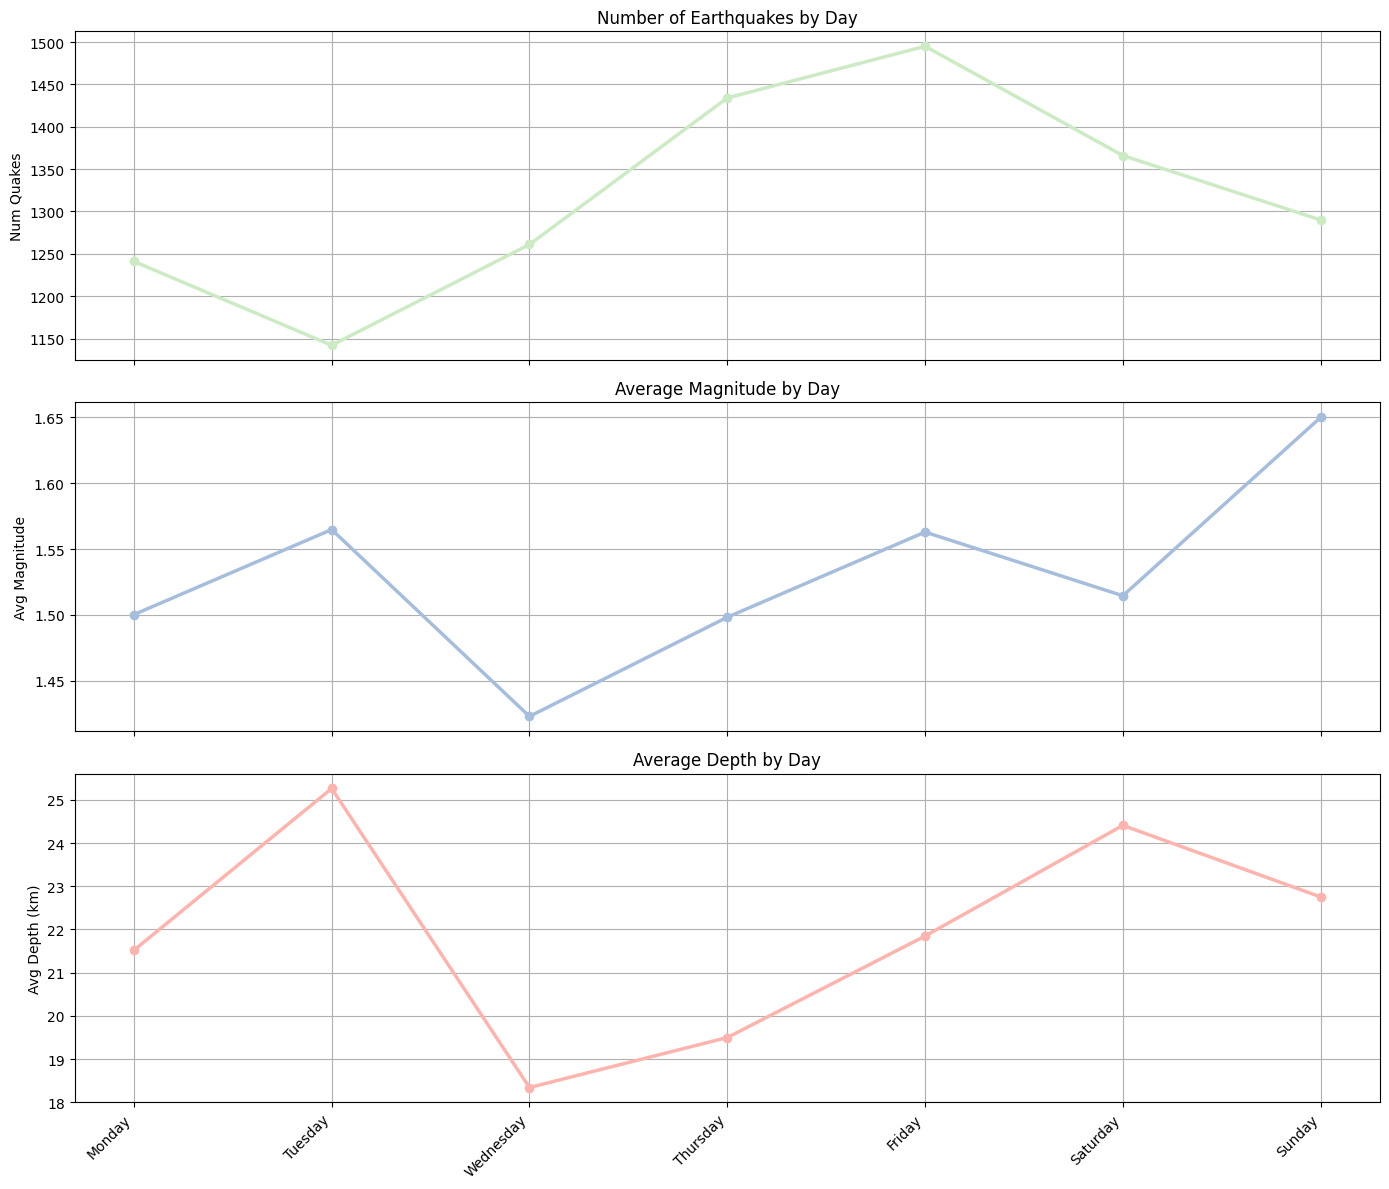

In [43]:
# Group by the day of the week
weekly_stats = earthquakes.groupby('day_of_week').agg(
    num_quakes=('time', 'count'),
    avg_mag=('mag', 'mean'),
    avg_depth=('depth', 'mean')
)

# Order the date
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_stats = weekly_stats.reindex(weekday_order)

fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot Number of Earthquakes
axs[0].plot(weekly_stats.index, weekly_stats['num_quakes'], marker='o', color='#ccebc5',linewidth=2.5)
axs[0].set_title('Number of Earthquakes by Day')
axs[0].set_ylabel('Num Quakes')
axs[0].grid(True)

# Plot Average Magnitude
axs[1].plot(weekly_stats.index, weekly_stats['avg_mag'], marker='o', color='#a6bddb', linewidth=2.5)
axs[1].set_title('Average Magnitude by Day')
axs[1].set_ylabel('Avg Magnitude')
axs[1].grid(True)

# Plot Average Depth
axs[2].plot(weekly_stats.index, weekly_stats['avg_depth'], marker='o', color='#fbb4ae', linewidth=2.5)
axs[2].set_title('Average Depth by Day')
axs[2].set_ylabel('Avg Depth (km)')
axs[2].grid(True)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


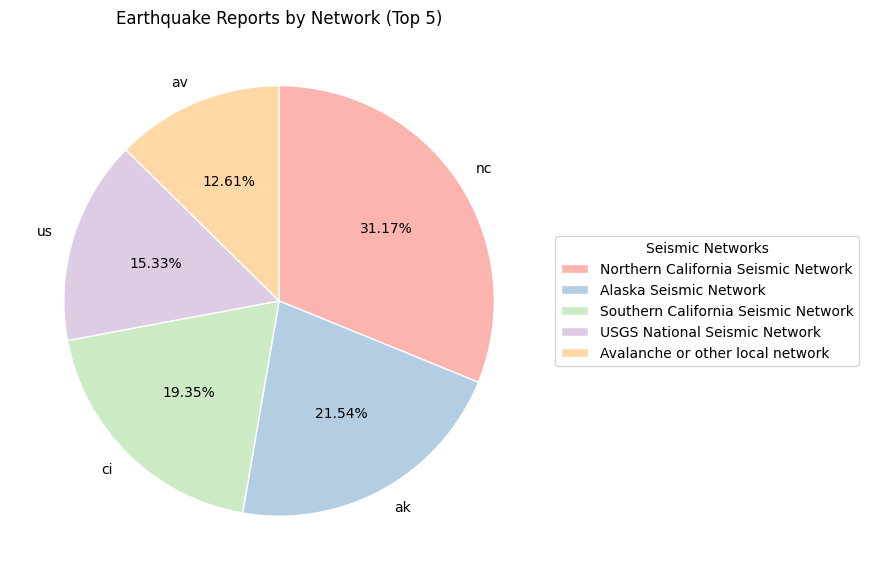

In [44]:
# Count network
network_counts = earthquakes['net'].value_counts().sort_index()

# Full network name
network_names = {
    'nc': 'Northern California Seismic Network',
    'ak': 'Alaska Seismic Network',
    'ci': 'Southern California Seismic Network',
    'us': 'USGS National Seismic Network',
    'av': 'Avalanche or other local network'
}

# Get top 5 counts
top5 = network_counts.nlargest(5)

# Plot pie chart
fig, ax = plt.subplots(figsize=(8,6))
wedges, texts, autotexts = ax.pie(
    top5.values,
    labels=top5.index,
    autopct='%1.2f%%',
    colors=colors,
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

# Add label, legend and show chart
full_labels = [network_names.get(code, code) for code in top5.index]
ax.legend(wedges, full_labels, title="Seismic Networks", loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Earthquake Reports by Network (Top 5)")
plt.ylabel('')
plt.tight_layout()
plt.show()

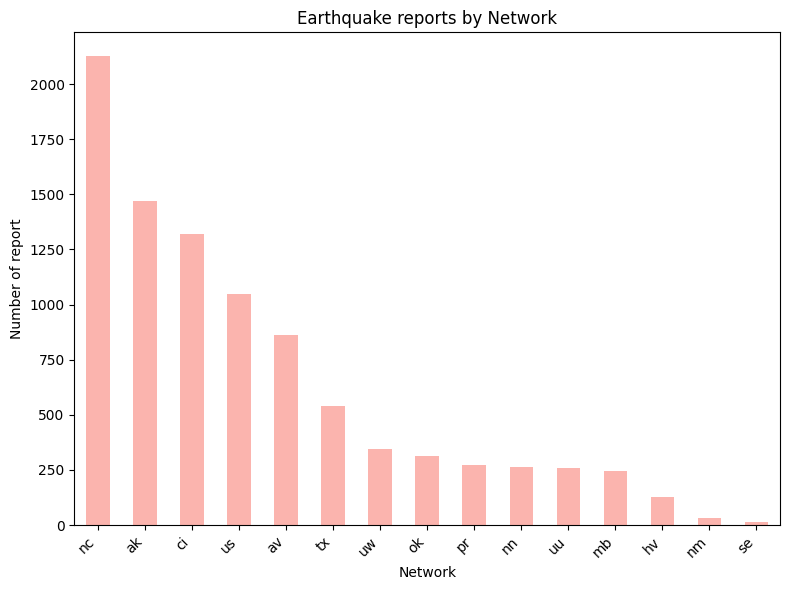

In [45]:
# Sorted by value
network_counts_sorted = network_counts.sort_values(ascending=False)

# Plot bar chart
fig, ax = plt.subplots(figsize=(8,6))
network_counts_sorted.plot(kind='bar', color='#fbb4ae', ax=ax)

# Add labels and title
ax.set_xlabel('Network')
ax.set_ylabel('Number of report')
ax.set_title('Earthquake reports by Network')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

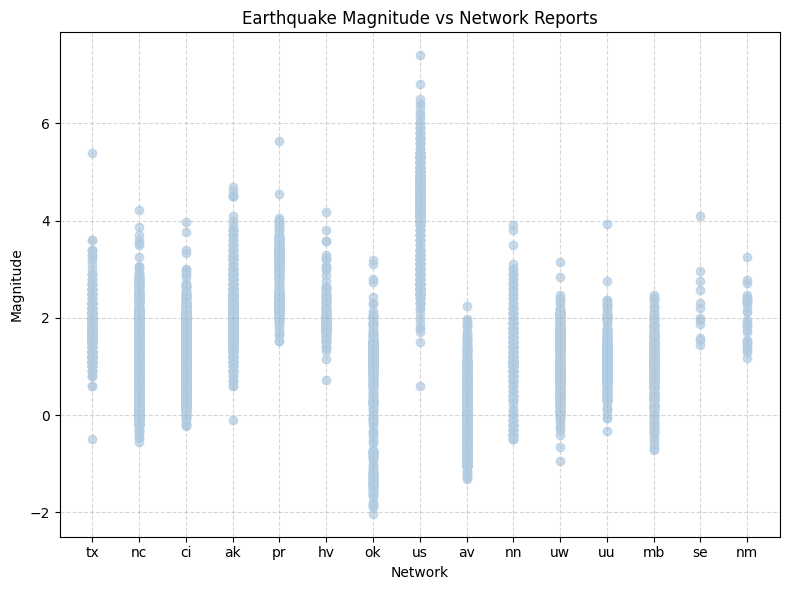

In [46]:
# Scatter plot
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(earthquakes['net'], earthquakes['mag'], color="#b3cde3", alpha=0.7)

# Labels and title
ax.set_xlabel('Network')
ax.set_ylabel('Magnitude')
ax.set_title('Earthquake Magnitude vs Network Reports')

# Grid
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

